In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
print(f'stoi: {stoi}')
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(f'itos: {itos}')
print(f'Size: {vocab_size}')

stoi: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Size: 27


In [5]:
# shuffle up words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[i.item()] for i in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [8]:
# torch like classes
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [9]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backdrop)
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
        
    def __call__(self, x):
        #calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)    # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps)   # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)* self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]    

In [10]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [11]:
torch.manual_seed(42)

In [12]:
n_embd = 20  # dimensionality of the character embedding vector
n_hidden = 300 # number of neuron in hidden layer of MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True


57267


In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]     # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)     # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # update : Simple SGD
    lr = 0.1 if i < 1500000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000:3.3023
  10000/ 200000:2.4293
  20000/ 200000:2.5279
  30000/ 200000:1.9513
  40000/ 200000:1.6534
  50000/ 200000:1.8742
  60000/ 200000:1.8805
  70000/ 200000:2.1136
  80000/ 200000:1.7854
  90000/ 200000:2.2734
 100000/ 200000:2.0153
 110000/ 200000:1.8047
 120000/ 200000:2.0131
 130000/ 200000:1.5729
 140000/ 200000:2.0965
 150000/ 200000:2.0266
 160000/ 200000:1.5808
 170000/ 200000:2.0690
 180000/ 200000:1.7428
 190000/ 200000:2.2213


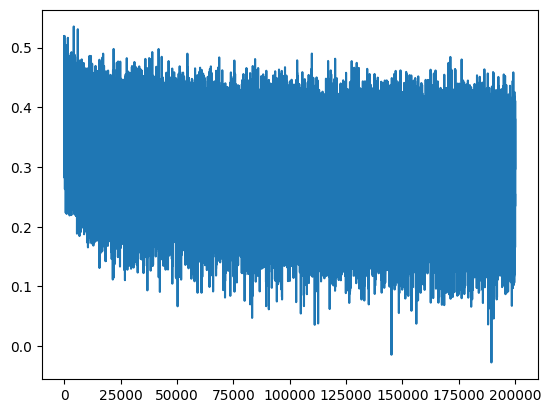

In [14]:
plt.plot(lossi)

In [15]:
# put layers in eval mode( specially needed for batch norm)
for layer in layers:
    layer.training = False

In [16]:
# evaluate the loss
@torch.no_grad()   # this disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'test': (Xdev, Ydev),
        'val': (Xte, Yte),
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')
    
    

train 1.8731261491775513
val 2.0973215103149414
test 2.0921220779418945


In [17]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]     # (1, block_size, n_embd)
        x = emb.view(emb.shape[0], -1)    # flatten out the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift  the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the specials '.' end token then stop
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
    

dawson.
arshmi.
jamanth.
khamauri.
taylan.
thazia.
hanshar.
lucian.
zahari.
valeon.
inesizher.
johnanny.
malikphem.
dokl.
jaycee.
dalida.
semaire.
kyndel.
ginas.
zaelyn.
